In [1]:
import xarray as xa
import pandas as pd
import numpy as np
import matplotlib as mlp
import datetime
import calendar
import matplotlib.pyplot as plt
%matplotlib inline


In [116]:
mlp.rcParams["figure.facecolor"] = "white"
mlp.rcParams["axes.facecolor"] = "white"

In [2]:
datapath = "../../MODIS-Aqua-SST-ChlorA-BBT/output/"

In [3]:
import os 

In [8]:
# Leyendo 2018
i = 0
datasets = []
for filename in os.listdir(datapath):
    if "SST" in filename: # and "MODA2018" in filename:
        dataset = xa.open_dataset(datapath + filename)
        datasets.append(dataset)
        i += 1

In [9]:
datasets = sorted(datasets, key= lambda x: int(x.attrs["product_name"][1:8]) ) 

In [11]:
datasets[-1].attrs["time_coverage_start"][0:10]

'2019-05-01'

In [12]:
# Confirmando que usan las mismas coordenadas
str(datasets[0].lat) == str(datasets[50].lat)

True

In [13]:
# Confirmando que usan las mismas coordenadas
str(datasets[0].lon) == str(datasets[150].lon)

True

In [14]:
concat = xa.concat([x["sst"] for x in datasets], pd.Index(data = pd.to_datetime([x.attrs["time_coverage_start"][0:10] for x in datasets]), name="date" ) )

In [16]:
def countnas(x, axis):
    return np.sum(np.isnan(x), axis)
    
cnas = concat.reduce(countnas, dim="date")

Text(0.5, 1.0, 'NAs count per pixel')

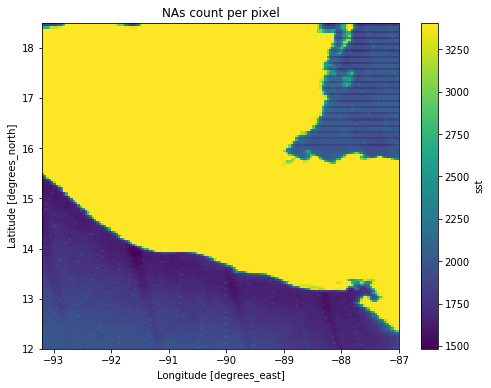

In [17]:
mlp.rcParams["figure.figsize"] = (8,6)

cnas.plot()
plt.title("NAs count per pixel")


In [18]:
# Definir un punto:
lat, lon = (13.5, -90.5)

In [20]:
# Tomando un punto al azar en la costa sur, contando los NAs (casi la mitad)
np.sum(np.isnan(concat.sel(lat = lat, lon=lon, method="nearest")).values) / (365*8.5)

0.5379532634971796

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  


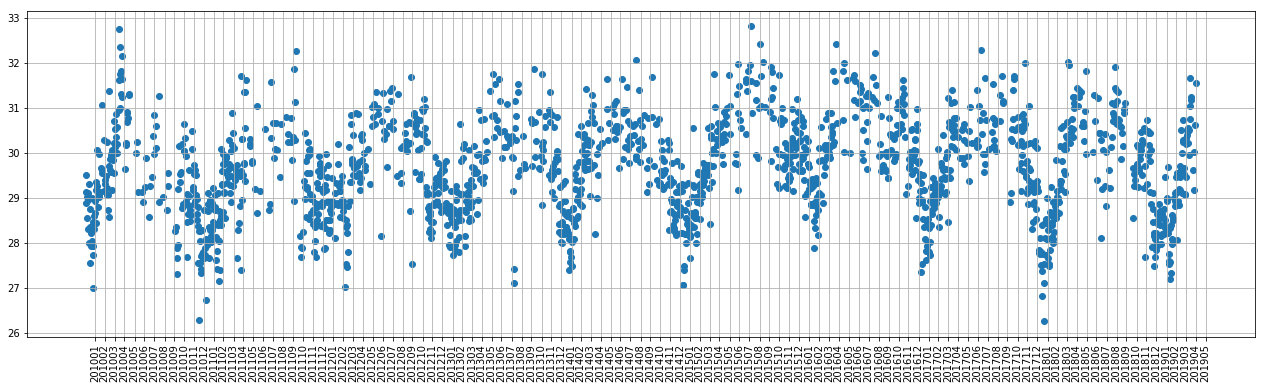

In [61]:
# Tomando un punto al azar en la costa sur, graficando
mlp.rcParams["figure.figsize"] = (22, 6)
plt.scatter(concat.date.values, concat.sel(lat = lat, lon=lon, method="nearest").values, marker="o")
#[plt.axvline(x, c="red") for x in np.cumsum([0,31,28,31,30,31,30,31,31,30,31,30,31]) ]
plt.grid("on")
index = pd.DatetimeIndex(start="2010-01-01", end="2019-06-01", freq="1M")
plt.xticks(index, index.map(lambda x: x.year *100 + x.month), rotation=90)
None

In [65]:
import scipy.stats as st

In [67]:
concat.shape

(3408, 156, 149)

array([29.5     , 28.885   , 29.13    , ..., 30.025   , 30.609999,
       31.539999], dtype=float32)

In [74]:
ys = concat.sel(lat = lat, lon=lon, method="nearest").values
result = st.linregress(np.arange(0, concat.shape[0], 1)[np.isnan(ys)==False] , ys[np.isnan(ys)==False])

In [82]:
1000*result.slope, 1000*( result.slope - 2* result.stderr), 1000*(result.slope + 2* result.stderr)

(0.13391286524428486, 0.0835549641463904, 0.18427076634217932)

In [48]:
#monthlymeans = concat.groupby("date.month").mean(dim="date")
resampling = concat.resample(date='1M')
monthlymeans = resampling.reduce(np.nanmean, dim="date")

/usr/local/lib/python3.6/dist-packages/xarray/core/variable.py:1371: RuntimeWarning: Mean of empty slice
  data = func(input_data, axis=axis, **kwargs)


In [118]:
def countNotNas(d,axis):
    return np.sum(np.isnan(d)==False, axis=axis)
monthlystd = resampling.reduce(np.nanstd, dim="date")
monthlyn = resampling.reduce(countNotNas, dim="date")
stderr = 2* monthlystd / np.sqrt(monthlyn)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  after removing the cwd from sys.path.


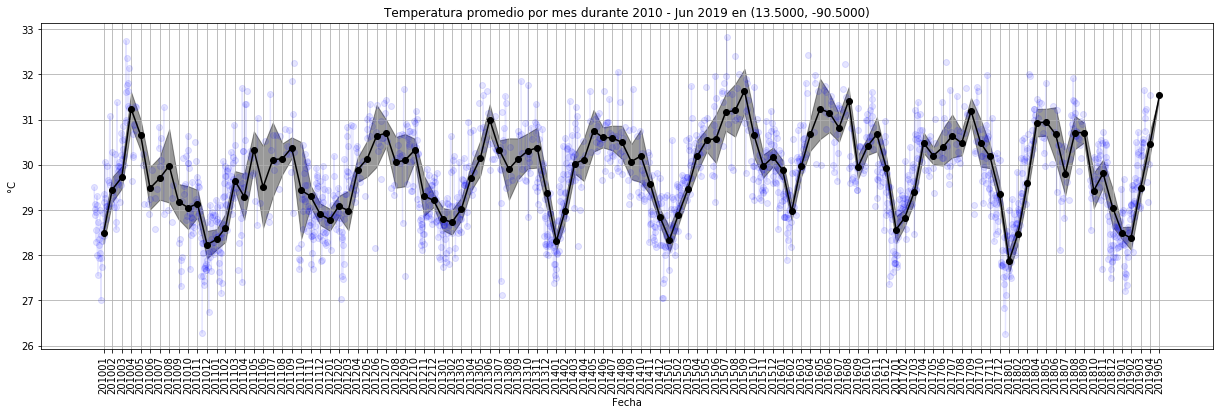

In [56]:
# Temperatura mensual
mlp.rcParams["figure.figsize"] = (21, 6)
ax = plt.subplot(111)
x = pd.DatetimeIndex(start="2010-01-01", end="2019-06-01", freq="1M")
y = monthlymeans.sel(lat = lat, lon=lon, method="nearest").values
err = stderr.sel(lat = lat, lon=lon, method="nearest").values

plt.plot(concat.date.values, concat.sel(lat = lat, lon=lon, method="nearest").values, marker="o", color="blue", alpha=0.1)

plt.plot(x, monthlymeans.sel(lat = lat, lon=lon, method="nearest").values, marker="o", color="black")
#plt.errorbar([calendar.month_abbr[i] for i in monthlymeans.month.values], monthlymeans.sel(lat = lat, lon=lon, method="nearest").values, marker="o", capsize=15,
#             yerr= stderr.sel(lat = lat, lon=lon, method="nearest").values)
plt.fill_between(x, y+err, y-err, color="black", alpha=0.4)

plt.grid("on")
plt.title("Temperatura promedio por mes durante 2010 - Jun 2019 en ({0:.4f}, {1:.4f})".format(lat,lon))

plt.xticks(x, x.map(lambda x: x.year *100 + x.month), rotation=90)
plt.ylabel("°C")
plt.xlabel("Fecha")

None

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  after removing the cwd from sys.path.


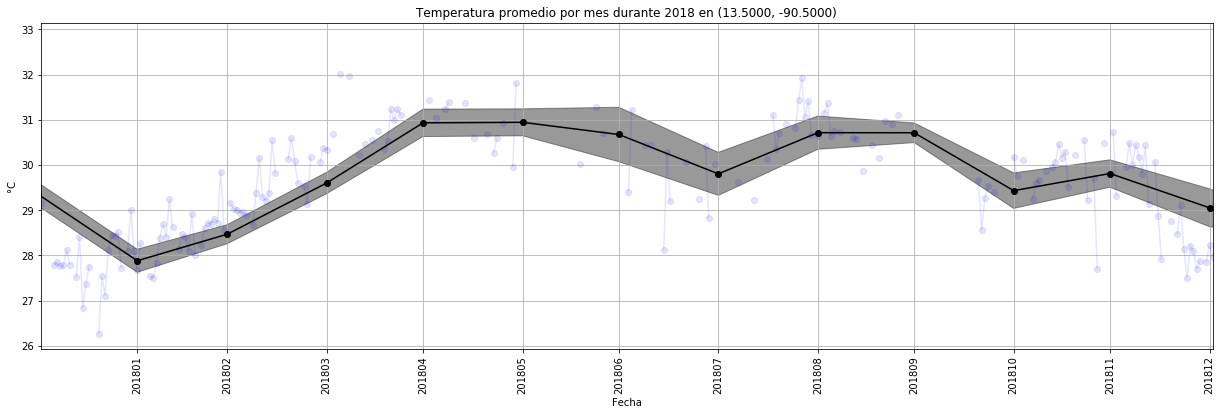

In [58]:
# Temperatura mensual
mlp.rcParams["figure.figsize"] = (21, 6)
ax = plt.subplot(111)
x = pd.DatetimeIndex(start="2010-01-01", end="2019-06-01", freq="1M")
y = monthlymeans.sel(lat = lat, lon=lon, method="nearest").values
err = stderr.sel(lat = lat, lon=lon, method="nearest").values

plt.plot(concat.date.values, concat.sel(lat = lat, lon=lon, method="nearest").values, marker="o", color="blue", alpha=0.1)

plt.plot(x, monthlymeans.sel(lat = lat, lon=lon, method="nearest").values, marker="o", color="black")
#plt.errorbar([calendar.month_abbr[i] for i in monthlymeans.month.values], monthlymeans.sel(lat = lat, lon=lon, method="nearest").values, marker="o", capsize=15,
#             yerr= stderr.sel(lat = lat, lon=lon, method="nearest").values)
plt.fill_between(x, y+err, y-err, color="black", alpha=0.4)

plt.grid("on")
plt.title("Temperatura promedio por mes durante 2018 en ({0:.4f}, {1:.4f})".format(lat,lon))

plt.xticks(x, x.map(lambda x: x.year *100 + x.month), rotation=90)
plt.xlim(pd.to_datetime("2018-01-01"), pd.to_datetime("2019-01-01"))

plt.ylabel("°C")
plt.xlabel("Fecha")

None

# Modis Terra

In [87]:
datapathT = "../../MODIS-Terra-SST-ChlorA-B/output/"

In [88]:
# Leyendo 2018
i = 0
datasetsT = []
for filename in os.listdir(datapathT):
    if "SST" in filename: 
        dataset = xa.open_dataset(datapathT + filename)
        datasetsT.append(dataset)
        i += 1

In [89]:
datasetsT = sorted(datasetsT, key= lambda x: int(x.attrs["product_name"][1:8]) ) 
datasetsT[-1].attrs["time_coverage_start"][0:10]

'2019-05-30'

In [90]:
datasetsT[0].attrs["time_coverage_start"][0:10]

'2012-02-06'

In [91]:
concatT = xa.concat([x["sst"] for x in datasetsT], pd.Index(data = pd.to_datetime([x.attrs["time_coverage_start"][0:10] for x in datasetsT]), name="date" ) )

In [92]:
# Definir un punto:
lat, lon = (13.5, -90.5)

In [94]:
# Tomando un punto al azar en la costa sur, contando los NAs (casi la mitad)
np.sum(np.isnan(concatT.sel(lat = lat, lon=lon, method="nearest")).values) / (365*8.5)

0.4728444802578566

In [113]:
#monthlymeans = concat.groupby("date.month").mean(dim="date")
resamplingT = concatT.resample(date='1M')
monthlymeansT = resamplingT.reduce(np.nanmean, dim="date")


def countNotNas(d,axis):
    return np.sum(np.isnan(d)==False, axis=axis)

monthlystdT = resamplingT.reduce(np.nanstd, dim="date")
monthlynT = resamplingT.reduce(countNotNas, dim="date")
stderrT = 2* monthlystdT / np.sqrt(monthlynT)

/usr/local/lib/python3.6/dist-packages/xarray/core/variable.py:1371: RuntimeWarning: Mean of empty slice
  data = func(input_data, axis=axis, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


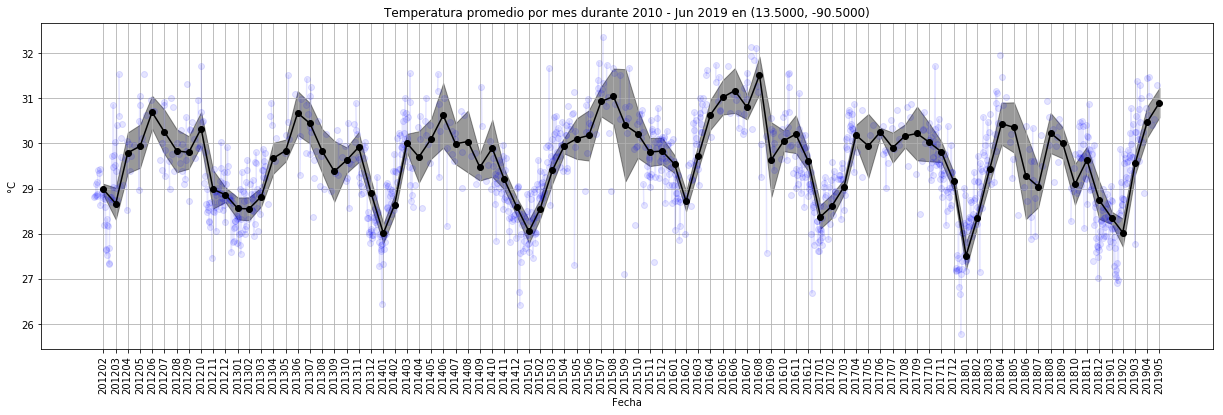

In [117]:
# Temperatura mensual
mlp.rcParams["figure.figsize"] = (21, 6)
ax = plt.subplot(111)
x = monthlymeansT.indexes["date"]
y = monthlymeansT.sel(lat = lat, lon=lon, method="nearest").values
err = stderr.sel(lat = lat, lon=lon, method="nearest").values

plt.plot(concatT.date.values, concatT.sel(lat = lat, lon=lon, method="nearest").values, marker="o", color="blue", alpha=0.1)

plt.plot(x, monthlymeansT.sel(lat = lat, lon=lon, method="nearest").values, marker="o", color="black")
#plt.errorbar([calendar.month_abbr[i] for i in monthlymeans.month.values], monthlymeans.sel(lat = lat, lon=lon, method="nearest").values, marker="o", capsize=15,
#             yerr= stderr.sel(lat = lat, lon=lon, method="nearest").values)
plt.fill_between(x, y+err, y-err, color="black", alpha=0.4)

plt.grid("on")
plt.title("Temperatura promedio por mes durante 2010 - Jun 2019 en ({0:.4f}, {1:.4f})".format(lat,lon))

plt.xticks(x, x.map(lambda x: x.year *100 + x.month), rotation=90)
plt.ylabel("°C")
plt.xlabel("Fecha")

None

Text(0.5, 0, 'Fecha')

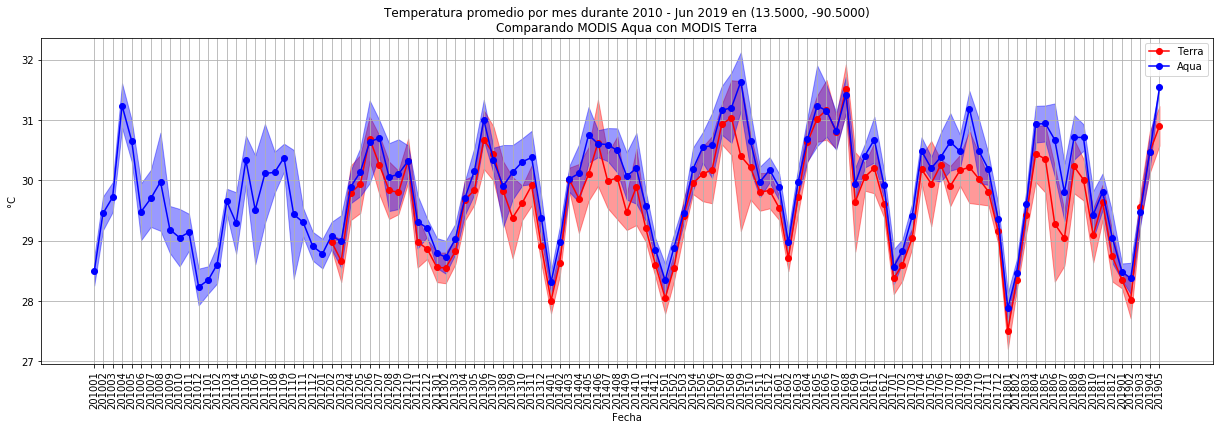

In [120]:
x = monthlymeansT.indexes["date"]
y = monthlymeansT.sel(lat = lat, lon=lon, method="nearest").values
err = stderrT.sel(lat = lat, lon=lon, method="nearest").values
plt.plot(x, monthlymeansT.sel(lat = lat, lon=lon, method="nearest").values, marker="o", color="red", label="Terra")
plt.fill_between(x, y+err, y-err, color="red", alpha=0.4)

x = monthlymeans.indexes["date"]
y = monthlymeans.sel(lat = lat, lon=lon, method="nearest").values
err = stderr.sel(lat = lat, lon=lon, method="nearest").values
plt.plot(x, monthlymeans.sel(lat = lat, lon=lon, method="nearest").values, marker="o", color="blue", label="Aqua")
plt.fill_between(x, y+err, y-err, color="blue", alpha=0.4)

plt.legend(loc="best")
plt.grid("on")
plt.title("Temperatura promedio por mes durante 2010 - Jun 2019 en ({0:.4f}, {1:.4f})\nComparando MODIS Aqua con MODIS Terra".format(lat,lon))
plt.xticks(x, x.map(lambda x: x.year *100 + x.month), rotation=90)
plt.ylabel("°C")
plt.xlabel("Fecha")
